In [28]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import graphviz
from sklearn import metrics

In [6]:
with open('eloVals.json') as f:
     eloDict = json.load(f)

df = pd.read_csv("allSeasonScores.csv")

In [7]:
# team is the team abbreviation (ARI, ATL, BAL, etc)
# year is the season. Note that if we are talking about the 2018-19 season, year would be 2018
# week is which week we are looking for the ELO rating in.
#     *** NOTE *** this function assumes that you are attempting to find the ELO at the start of a week, meaning
#                  that if you passed 'week = 1' it would be the teams rating BEFORE the game was played. 
#                  this explains why it is '...[week - 1]...' in the 'try' part of the below function
# unit is either 'off' (offense) or 'def' (defense)
# data is the dictionary object
def getInitialEloRating(team, year, week, unit, data = eloDict):
    try:
        return data[team][str(year)][str(week - 1)][unit]
    except:
        # What if we are missing that week? For instance, the bucs dolphins game in 2017 week 1 was postponed
        # until week 11 because of a hurricane. So if you tried something like...
        # data['MIA'][2017][2]['off'] you would get an error...
        # the solution to this problem is that we are going to try and find the most recent ELO ratings.
        # it is guaranteed that for each team, for each season, there exists their week 0, or initial, elo ratings which
        # are based on their ending values from the prevrious season. So in the example above (bucs dolphins) we would end
        # up with the initial rank at week 0.
        #print(team + str(year) + str(week) + unit)
        season = data[team][str(year)]
        
        # descending order...
        for w in range(week - 1,-1, -1):
            try:
                return season[str(w)][unit]
            except:
                pass
            
def determineEra(year):
    year = int(year)
    if year >= 2015:
        return 4
    elif year >= 2010:
        return 3
    elif year >= 2005:
        return 2
    else:
        return 1

In [8]:
df['homeDiff'] = df.homeOffPoints - df.awayDefPoints
df['awayDiff'] = df.awayOffPoints - df.homeOffPoints

n = len(df.homeTeam)

homeOff = [None] * n
homeDef = [None] * n
awayOff = [None] * n
awayDef = [None] * n


for i, (h,a,y,w) in enumerate(zip(df.homeTeam, df.awayTeam, df.season, df.week)):
    homeOff[i] = getInitialEloRating(team = h, unit = 'off', week = w, year = y, data = eloDict)
    awayOff[i] = getInitialEloRating(team = a, unit = 'off', week = w, year = y, data = eloDict)
    awayDef[i] = getInitialEloRating(team = a, unit = 'def', week = w, year = y, data = eloDict)
    homeDef[i] = getInitialEloRating(team = h, unit = 'def', week = w, year = y, data = eloDict)

#df = df.assign(homeOffElo = lambda x: getInitialEloRating(team=x['homeTeam'], unit='off', week=x['week'], year=x['season'])) 

In [9]:
df['homeOffElo'] = homeOff
df['awayOffElo'] = awayOff
df['homeDefElo'] = homeDef
df['awayDefElo'] = awayDef

df['era'] = df.apply(lambda x: determineEra(x['season']), axis = 1)

In [10]:
df

,Unnamed: 0,season,week,homeTeam,awayTeam,awayDefPoints,homeDefPoints,awayOffPoints,homeOffPoints,homeDiff,awayDiff,homeOffElo,awayOffElo,homeDefElo,awayDefElo,era
0,1,1999,1,PHI,ARI,0,0,26,24,24,2,1500.000000,1500.000000,1500.000000,1500.000000,1
1,2,1999,1,IND,BUF,0,7,13,24,24,-11,1500.000000,1500.000000,1500.000000,1500.000000,1
2,3,1999,1,NO,CAR,0,7,10,13,13,-3,1500.000000,1500.000000,1500.000000,1500.000000,1
3,4,1999,1,TEN,CIN,0,0,34,34,34,0,1500.000000,1500.000000,1500.000000,1500.000000,1
4,5,1999,1,WAS,DAL,0,0,42,34,34,8,1500.000000,1500.000000,1500.000000,1500.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5344,5345,2019,17,NYG,PHI,0,0,34,17,17,17,1431.434009,1546.065708,1367.343242,1507.175368,4
5345,5346,2019,17,BAL,PIT,0,7,10,19,19,-9,1692.061422,1386.667316,1674.568299,1633.982018,4
5346,5347,2019,17,SEA,SF,0,0,27,21,21,6,1506.258527,1569.234573,1487.387715,1577.729177,4
5347,5348,2019,17,HOU,TEN,0,0,35,14,14,21,1560.197469,1576.266102,1479.871165,1548.355055,4


In [11]:
tableA = pd.DataFrame({'era' : df.era, 'offElo' : df.homeOffElo, 'defElo' : df.awayDefElo, 
                       'home' : 1, 'pointDiff' : df.homeDiff})

tableB = pd.DataFrame({'era' : df.era, 'offElo' : df.awayOffElo, 'defElo' : df.homeDefElo, 
                       'home' : 0, 'pointDiff' : df.awayDiff})

In [23]:
tableB.iloc[:, 0:-1]
data = tableA.append(tableB)

msk = np.random.rand(len(data)) < 0.8

train = data[msk]

test = data[~msk]

dtrain = xgb.DMatrix(data=train.iloc[:, 0:-1], label=train.pointDiff)
dtest = xgb.DMatrix(data=test.iloc[:, 0:-1], label=test.pointDiff)

In [24]:
bst = xgb.train(dtrain=dtrain, params=[])

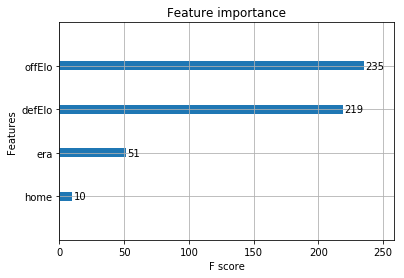

In [25]:
p1 = xgb.plot_importance(bst)

In [26]:
ypred = bst.predict(dtest)

In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test.pointDiff, ypred))
print('Mean Squared Error:', metrics.mean_squared_error(test.pointDiff, ypred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test.pointDiff, ypred)))

LR Mean Absolute Error: 9.290301354317348
LR Mean Squared Error: 143.16043559025763
LR Root Mean Squared Error: 11.964967011666085
